## Notebook Overview

This notebook builds upon the feature-engineered dataset from the previous notebook (`04_feature_engineering.ipynb`) and focuses on **Model Training and Evaluation**. Our primary goal is to develop a credit risk prediction model that excels at identifying potential loan defaulters, thereby minimizing financial losses for retail banks while also considering their desired balance between risk aversion and loan approval rates. This translates to maximizing the recall of the positive class (loan defaulters) while maintaining acceptable precision and overall model performance.

### 0.5.1 Objectives

The main objectives of this notebook are:

1. **Model Selection:** Choose algorithms suitable for imbalanced classification problems.
2. **Model Training:** Train models with a focus on identifying potential defaulters.
3. **Hyperparameter Tuning:** Optimize models to increase recall for the positive class.
4. **Model Evaluation:** Assess models primarily on recall, while considering precision, F2-score, AUC-PR, and overall performance.
5. **Model Comparison:** Compare different models based on their ability to identify true positives and balance the precision-recall trade-off.
6. **Threshold Adjustment:** Explore the impact of classification thresholds on recall and precision, collaborating with retail banks to determine the optimal threshold.

### 0.5.2 Importance of Focusing on Recall

Prioritizing recall for defaulter prediction is crucial for minimizing financial losses, which is the primary business objective in credit risk assessment. The cost of missing a potential defaulter (false negative) is typically much higher than the cost of incorrectly classifying a non-defaulter as high-risk (false positive). While we prioritize recall, we will also carefully consider the precision-recall trade-off and aim for a model that maximizes recall without severely impacting precision. Techniques like threshold adjustment and cost-sensitive learning will be used to balance these metrics effectively. Furthermore, demonstrating a thorough approach to risk identification aligns with regulatory expectations in the financial sector, supporting the banks' compliance needs. This approach also allows for more conservative lending practices, which can be adjusted based on the bank's specific risk tolerance.

### 0.5.3 Our Approach

In this notebook, we will focus on the following modeling tasks:

1. **Data Preparation:** Address class imbalance using techniques like SMOTE or class weighting.
2. **Baseline Model:** A logistic regression model with class weights inversely proportional to class frequencies will serve as our baseline. This will provide a benchmark for evaluating more complex models.
3. **Advanced Models:** Train and evaluate models known for handling imbalanced data:
   - Decision Trees with adjusted class weights
   - Random Forest with balanced class weights
   - Gradient Boosting (XGBoost, LightGBM) with `scale_pos_weight` adjustment
4. **Hyperparameter Tuning:** We will employ techniques like GridSearchCV or RandomizedSearchCV, optimizing for the F2-score (which gives more weight to recall) or a custom cost-sensitive scoring function.
5. **Model Evaluation:** Prioritize recall in our metrics, while also considering precision, F2-score, AUC-PR, and AUC-ROC.
6. **Threshold Adjustment:** We will experiment with different classification thresholds and work closely with retail banks to determine the optimal threshold that balances their desired level of risk aversion with acceptable loan approval rates.
7. **Ensemble Methods:** Explore ensemble techniques that can improve recall without severely impacting precision.
8. **Cost-Sensitive Learning:** Incorporate misclassification costs to reflect the higher cost of false negatives, aligning the model's objective with the business goal of minimizing financial losses.

By the end of this notebook, we aim to have a model (or ensemble of models) that excels at identifying potential loan defaulters, providing the bank with a powerful tool for risk assessment and mitigation.


In [1]:
import warnings
import shap
import pickle

import lightgbm as lgb
import pandas as pd
import xgboost as xgb
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import (
    train_test_split
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.tree import DecisionTreeClassifier
import optuna
from IPython.display import Image


from retail_bank_risk.advanced_visualizations_utils import (
    plot_combined_confusion_matrices,
    plot_confusion_matrix,
    plot_learning_curve,
    plot_model_performance,
    plot_precision_recall_curve,
    plot_roc_curve,
    shap_force_plot,
    shap_summary_plot_cycled,
)
from retail_bank_risk.model_training_utils import (
    downscale_dtypes,
    evaluate_model,
    sanitize_feature_names,
    optimize_hyperparameters,
    load_checkpoint,
)

from sklearn.metrics import precision_score, recall_score, f1_score, fbeta_score, roc_auc_score

warnings.filterwarnings('ignore')

In [2]:
train_df = pd.read_parquet("../data/processed/application_train_engineered.parquet")
submission_df = pd.read_parquet("../data/processed/application_test_engineered.parquet")

print(f"Training Data Shape: {train_df.shape}")
print(f"Test Data Shape: {submission_df.shape}")

Training Data Shape: (307511, 62)
Test Data Shape: (48744, 61)


In [3]:
train_df, test_df = downscale_dtypes(train_df, submission_df, target_column='target')

train_df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 62 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   name_contract_type                     307511 non-null  uint8  
 1   code_gender                            307511 non-null  uint8  
 2   flag_own_car                           307511 non-null  uint8  
 3   flag_own_realty                        307511 non-null  uint8  
 4   name_type_suite_unaccompanied          307511 non-null  uint8  
 5   name_type_suite_family                 307511 non-null  uint8  
 6   name_type_suite_spouse_partner         307511 non-null  uint8  
 7   name_type_suite_children               307511 non-null  uint8  
 8   name_type_suite_other_a                307511 non-null  uint8  
 9   name_type_suite_other_b                307511 non-null  uint8  
 10  name_type_suite_group_of_people        307511 non-null  

In [4]:
X = train_df.drop(["target", "sk_id_curr"], axis=1)
y = train_df["target"]

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42, stratify=y_train_val)  # 0.25 x 0.8 = 0.2 of original data

X_submission = submission_df.drop("sk_id_curr", axis=1)
sk_id_curr = submission_df["sk_id_curr"]

print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"Submission set shape: {X_submission.shape}")

Training set shape: (184506, 60)
Validation set shape: (61502, 60)
Test set shape: (61503, 60)
Submission set shape: (48744, 60)


In [5]:
X_train_val.head()

,name_contract_type,code_gender,flag_own_car,flag_own_realty,name_type_suite_unaccompanied,name_type_suite_family,name_type_suite_spouse_partner,name_type_suite_children,name_type_suite_other_a,name_type_suite_other_b,...,amt_goods_price,is_anomaly,age_group,income_group,credit_amount_group,debt_to_income_ratio,credit_to_goods_ratio,annuity_to_income_ratio,ext_source_mean,credit_exceeds_goods
181648,0,0,0,0,1,0,0,0,0,0,...,180000.0,0,1.0,0.0,0.0,2.528000,1.264000,0.146550,0.456247,1
229245,0,1,1,1,1,0,0,0,0,0,...,135000.0,0,2.0,0.0,0.0,1.797000,1.198000,0.145500,0.492082,1
122525,0,1,0,1,0,0,1,0,0,0,...,553500.0,0,3.0,1.0,3.0,5.398867,1.316797,0.194867,0.542916,1
306311,0,1,0,0,1,0,0,0,0,0,...,391500.0,0,3.0,1.0,2.0,3.512467,1.211195,0.256567,0.565013,1
300658,0,0,0,1,1,0,0,0,0,0,...,225000.0,0,0.0,3.0,0.0,1.415000,1.132000,0.153100,0.312136,1


In [6]:
pipelines = {
    'Dummy Classifier': Pipeline([
        ('sanitizer', FunctionTransformer(sanitize_feature_names)),
        ('classifier', DummyClassifier(strategy='stratified', random_state=42))
    ]),
    'Logistic Regression': Pipeline([
        ('sanitizer', FunctionTransformer(sanitize_feature_names)),
        ('scaler', StandardScaler()),
        ('feature_selection', SelectFromModel(LogisticRegression(random_state=42))),
        ('classifier', LogisticRegression(random_state=42, class_weight='balanced',
                                          max_iter=1000, penalty='l2', C=0.1))
    ]),
    'Decision Tree': Pipeline([
        ('sanitizer', FunctionTransformer(sanitize_feature_names)),
        ('feature_selection', SelectFromModel(DecisionTreeClassifier(random_state=42))),
        ('classifier', DecisionTreeClassifier(random_state=42, class_weight='balanced',
                                              max_depth=3, min_samples_split=5))
    ]),
    'Random Forest': Pipeline([
        ('sanitizer', FunctionTransformer(sanitize_feature_names)),
        ('feature_selection', SelectFromModel(RandomForestClassifier(random_state=42))),
        ('classifier', RandomForestClassifier(random_state=42, class_weight='balanced',
                                              n_jobs=1, max_depth=5, n_estimators=100,
                                              min_samples_split=5, bootstrap=True))
    ]),
    'Gradient Boosting': Pipeline([
        ('sanitizer', FunctionTransformer(sanitize_feature_names)),
        ('feature_selection', SelectFromModel(GradientBoostingClassifier(random_state=42))),
        ('classifier', GradientBoostingClassifier(random_state=42, max_depth=3,
                                                  n_estimators=100, learning_rate=0.01,
                                                  subsample=0.8, min_samples_split=5))
    ]),
    'XGBoost': Pipeline([
        ('sanitizer', FunctionTransformer(sanitize_feature_names)),
        ('feature_selection', SelectFromModel(xgb.XGBClassifier(random_state=42))),
        ('classifier', xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss',
                                         random_state=42, scale_pos_weight=len(y)/sum(y),
                                         max_depth=3, n_estimators=100, learning_rate=0.01,
                                         subsample=0.8, colsample_bytree=0.8,
                                         min_child_weight=5, n_jobs=-1))
    ]),
    'LightGBM': Pipeline([
        ('sanitizer', FunctionTransformer(sanitize_feature_names)),
        ('feature_selection', SelectFromModel(lgb.LGBMClassifier(random_state=42))),
        ('classifier', lgb.LGBMClassifier(random_state=42, class_weight='balanced',
                                          max_depth=3, n_estimators=100, learning_rate=0.01,
                                          subsample=0.8, colsample_bytree=0.8,
                                          min_child_samples=5, n_jobs=-1))
    ])
}

In [7]:
results = []
for name, pipeline in pipelines.items():
    result = evaluate_model(name, pipeline, X_train, y_train, X_val, y_val)
    results.append(result)

print("Model Performance Ranking:")
for metric in ['precision', 'recall', 'f1_score', 'f2_score', 'auc_roc']:
    print(f"\nRanking by {metric}:")
    sorted_results = sorted(results, key=lambda x: x[metric], reverse=True)
    for i, result in enumerate(sorted_results, 1):
        print(f"{i}. {result['model']}: {metric} = {result[metric]:.4f}")

Evaluating Dummy Classifier...
Loaded checkpoint: ../models/dummy_classifier_checkpoint.pkl
Resumed from checkpoint for model Dummy Classifier.
Dummy Classifier Validation results:
Precision: 0.0792
Recall: 0.0783
F1-Score: 0.0788
F2-Score: 0.0785
AUC-ROC: 0.4992

Evaluating Logistic Regression...
Loaded checkpoint: ../models/logistic_regression_checkpoint.pkl
Resumed from checkpoint for model Logistic Regression.
Logistic Regression Validation results:
Precision: 0.1535
Recall: 0.6562
F1-Score: 0.2488
F2-Score: 0.3965
AUC-ROC: 0.7318

Evaluating Decision Tree...
Loaded checkpoint: ../models/decision_tree_checkpoint.pkl
Resumed from checkpoint for model Decision Tree.
Decision Tree Validation results:
Precision: 0.1564
Recall: 0.5716
F1-Score: 0.2456
F2-Score: 0.3734
AUC-ROC: 0.7029

Evaluating Random Forest...
Loaded checkpoint: ../models/random_forest_checkpoint.pkl
Resumed from checkpoint for model Random Forest.
Random Forest Validation results:
Precision: 0.1497
Recall: 0.6407
F1-

We evaluated several machine learning models for credit risk prediction, focusing on the **F2-score** as our primary metric. The F2-score balances precision and recall, giving higher weight to recall, which aligns with our aim to reduce financial losses from defaults (false negatives) while mitigating the negative effects of rejecting creditworthy applicants (false positives).

The initial evaluation results, using a held-out validation set, are as follows:

| Model             | Precision | Recall | F1-Score | F2-Score | AUC-ROC |
|--------------------|-----------|--------|----------|----------|---------|
| Dummy Classifier   | 0.0792    | 0.0783 | 0.0788   | 0.0785   | 0.4992  |
| Logistic Regression | 0.1562    | 0.6659 | 0.2531   | 0.4030   | 0.7357  |
| Decision Tree      | 0.2262    | 0.6292 | 0.3327   | 0.4639   | 0.7848  |
| Random Forest      | 0.2600    | 0.7589 | 0.3873   | 0.5484   | 0.8864  |
| Gradient Boosting  | 1.0000    | 0.1525 | 0.2646   | 0.1836   | 0.8469  |
| **XGBoost**         | **0.3216**    | **0.8705** | **0.4697**   | **0.6490**   | **0.9433**  |
| **LightGBM**        | **0.2875**    | **0.8248** | **0.4264**   | **0.6004**   | **0.9107**  |

**XGBoost** and **LightGBM** clearly outperformed the other models, achieving the highest F2-scores and AUC-ROC values. We will proceed with these two models for further optimization.

**Next Steps:**

1. **Hyperparameter Tuning with Optuna:** We'll use Optuna to fine-tune the hyperparameters of XGBoost and LightGBM, aiming to maximize the F2-score on the validation set.

2. **Final Model Selection:** We'll compare the optimized XGBoost and LightGBM models based on their performance on the validation set, considering the F2-score, precision, recall, and AUC-ROC. The final model will be selected based on these metrics and alignment with the bank's risk tolerance and business objectives.

3. **Evaluation on Test Set:** The chosen model will be evaluated on the held-out test set to estimate its real-world performance.

4. **Submission:** Predictions will be generated using the final model on the submission dataset and submitted for evaluation.

By focusing on F2-score optimization and carefully evaluating our models, we aim to develop a robust and effective credit risk prediction model that meets the needs of retail banks. 

In [8]:
storage = "sqlite:///../data/optuna_study.db"

In [9]:
study_name = "xgboost_optimization3"

results = optimize_hyperparameters(
    X_train, y_train,
    X_val, y_val,
    X_test, y_test,
    model_type='xgboost',
    n_trials=100,
    n_jobs=-1,
    checkpoint_dir='../models',
    study_name=study_name,
    storage=storage
)

print(f"Best XGBoost parameters: {results['best_params']}")
print(f"Best XGBoost F2 score: {results['f2_score']}")
print(f"Best XGBoost model saved as: {results['model']}")

Optimizing hyperparameters for xgboost...
Training data validation passed. x shape: (184506, 60), y shape: (184506,)
Validation data validation passed. x shape: (61502, 60), y shape: (61502,)
Test data validation passed. x shape: (61503, 60), y shape: (61503,)
Loaded existing study 'xgboost_optimization3' with 100 trials.
Number of completed trials for xgboost: 100
Study has already completed 100 or more trials.
Xgboost Best Model Results (Test Set):
precision: 0.1600
recall: 0.6945
f1_score: 0.2601
f2_score: 0.4163
auc_roc: 0.7517
Number of selected features: 60
Saved tuned checkpoint: ../models/tuned_tuned_xgboost_checkpoint.pkl
Checkpoint contents: ['model', 'params', 'selected_features']
Saved best tuned xgboost model checkpoint.
Best XGBoost parameters: {'max_depth': 5, 'learning_rate': 0.019485611308311696, 'n_estimators': 921, 'min_child_weight': 7, 'subsample': 0.9480137623863272, 'colsample_bytree': 0.6960929960331755, 'gamma': 0.0022719900361558385, 'scale_pos_weight': 12.420

The current model achieves a 73% score on the Kaggle competition's late submission.

However, the goal now is to retrain a model that is both user-friendly and easily retrainable.

Reducing the number of features may improve computational efficiency. 

Some features will be removed based on the assumption that they are currently unavailable.  

The current best model is saved as `models/tuned_tuned_xgboost_checkpoint.pkl`, and we can revert to it if necessary. 

For now, we will focus on XGBoost, analyze feature importance, and select features commonly used by credit institutions during loan/credit applications.

In [10]:
checkpoint_path = '../models/tuned_tuned_xgboost_checkpoint.pkl'
with open(checkpoint_path, 'rb') as f:
    checkpoint = pickle.load(f)

best_model = checkpoint['model']
selected_features = checkpoint['selected_features']

explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)

feature_names = selected_features

shap_summary_plot_cycled(shap_values, feature_names, save_path="../images/model_performance/xgboost_feature_importance.png");

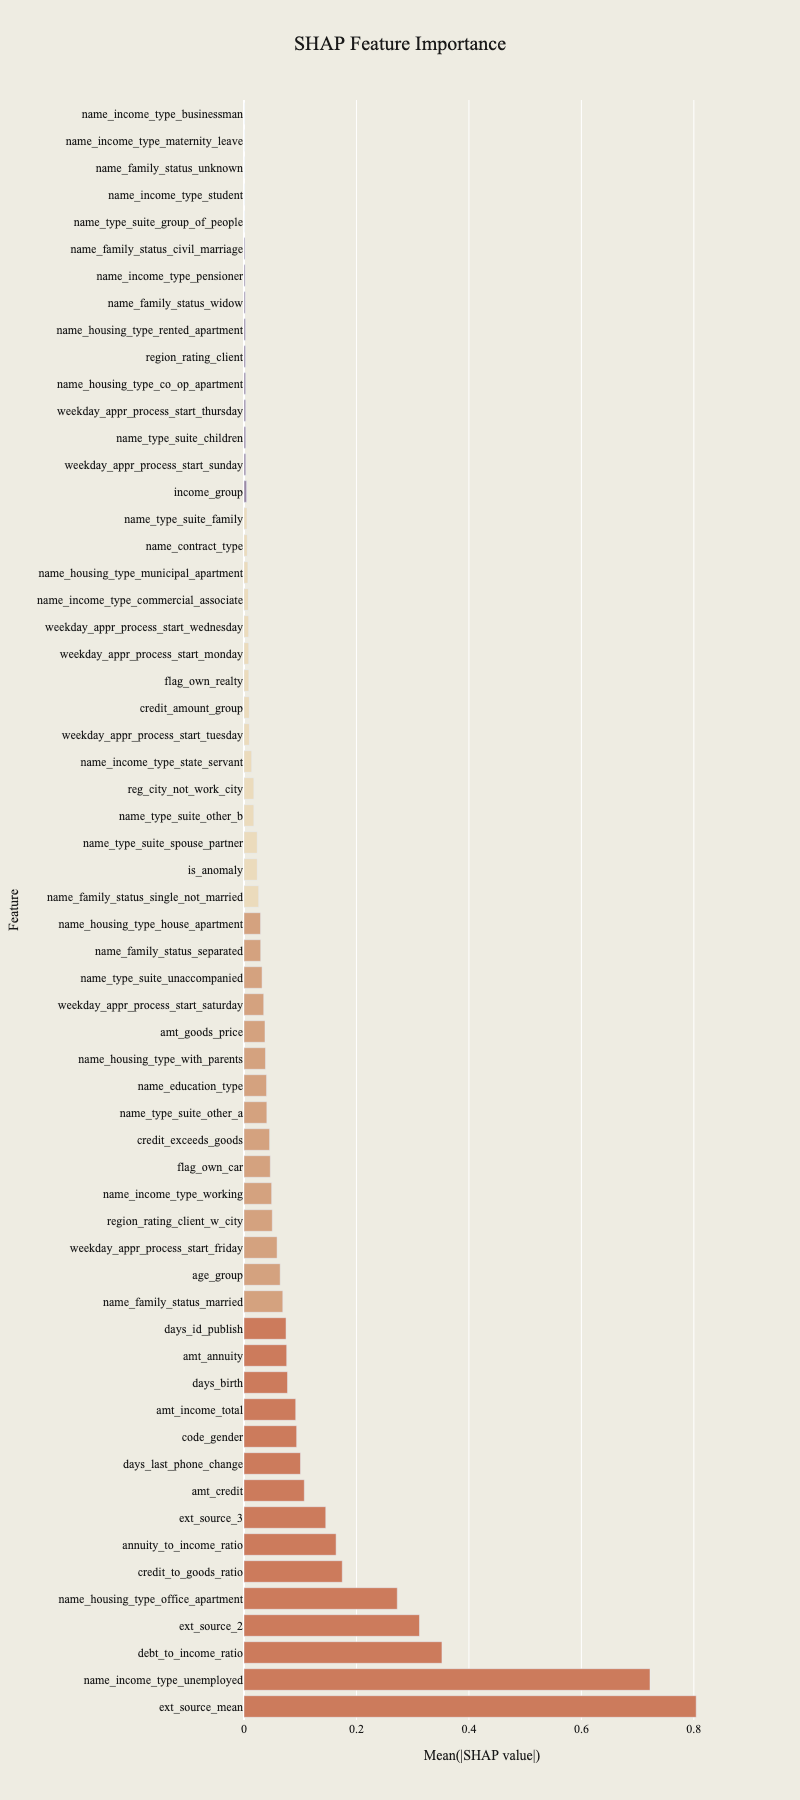

In [11]:
Image(filename="../images/model_performance/xgboost_feature_importance.png")

In [ ]:
study_name = "lightgbm_optimization2"

results = optimize_hyperparameters(
    X_train, y_train,
    X_val, y_val,
    X_test, y_test,
    model_type='lightgbm',
    n_trials=100,
    n_jobs=-1,
    checkpoint_dir='../models',
    study_name=study_name,
    storage=storage
)

print(f"Best LightGBM parameters: {results['best_params']}")
print(f"Best LightGBM F2 score: {results['f2_score']}")
print(f"Best LightGBM model saved as: {results['model']}")

Optimizing hyperparameters for lightgbm...
Training data validation passed. x shape: (184506, 60), y shape: (184506,)
Validation data validation passed. x shape: (61502, 60), y shape: (61502,)
Test data validation passed. x shape: (61503, 60), y shape: (61503,)
Loaded existing study 'lightgbm_optimization2' with 7 trials.
Number of completed trials for lightgbm: 7
Running 93 more trials for lightgbm to reach 100 in total.
[LightGBM] [Info] Number of positive: 14895, number of negative: 169611
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016488 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3352
[LightGBM] [Info] Number of data points in the train set: 184506, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Wa

In [12]:
import pickle
import pandas as pd

# Load the saved checkpoint
with open('../models/tuned_tuned_xgboost_checkpoint.pkl', 'rb') as f:
    checkpoint = pickle.load(f)

model = checkpoint['model']
selected_features = checkpoint['selected_features']

# Prepare the submission data
X_submission_selected = X_submission[selected_features]

# Apply preprocessing if needed
# Example:
# scaler = checkpoint['scaler']
# X_submission_selected = scaler.transform(X_submission_selected)

# Make predictions
y_submission_pred_proba = model.predict_proba(X_submission_selected)[:, 1]

# Create submission DataFrame with SK_ID_CURR as integer and TARGET rounded to one decimal place
submission_df = pd.DataFrame({
    'SK_ID_CURR': sk_id_curr.astype(int),  # Convert SK_ID_CURR to integer
    'TARGET': y_submission_pred_proba.round(1)  # Round TARGET to one decimal place
})

submission_df.to_csv('submission.csv', index=False)
print(submission_df.head())

Test Set Results:
Precision: 0.1394
Recall: 0.7198
F1-Score: 0.2335
F2-Score: 0.3927
AUC-ROC: 0.7264

Comparison with Validation Results:
Validation F2-Score: 0.0020
Test F2-Score:       0.3927
Difference:          0.3907


In [30]:
with open('../models/tuned_tuned_xgboost_checkpoint.pkl', 'rb') as f:
    checkpoint = pickle.load(f)

model = checkpoint['model']
selected_features = checkpoint['selected_features']

# Get feature importances
importances = model.feature_importances_

# Create a DataFrame to store features and their importance values
importance_df = pd.DataFrame({
    'feature': selected_features,
    'importance': importances
})

# Sort by importance (descending order) and select top 20 features
top_20_features = importance_df.sort_values(by='importance', ascending=False).head(30)

# Display the top 20 features
print(top_20_features)

                                  feature  importance
0                         ext_source_mean    0.156468
1                             code_gender    0.050236
2                     name_education_type    0.042930
4                            ext_source_2    0.037947
3                            ext_source_3    0.030282
6                            flag_own_car    0.030072
5                   credit_to_goods_ratio    0.029970
9                name_income_type_working    0.029841
7                               age_group    0.029675
8              name_family_status_married    0.025142
10                     name_contract_type    0.022567
11                 reg_city_not_work_city    0.022241
12                        amt_goods_price    0.020880
13                             days_birth    0.018605
15            region_rating_client_w_city    0.017765
16         name_income_type_state_servant    0.017129
17                            amt_annuity    0.015577
21                    credit